# DA24C001

# Assignment - 8

In [1]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.utils import resample
from sklearn.datasets import make_moons, make_circles
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
## setting plot syling
sns.set_style("whitegrid")

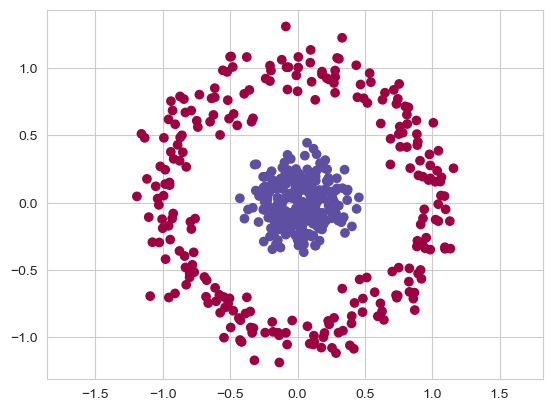

In [3]:
## Creating the dataset

X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
y[y==0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap="Spectral")
plt.axis('equal')
plt.show()

## Task-1

### Adaboost algorithm from scratch

sklearn's BaseEstimator and ClassifierMixin classes have been used as parent classes to implement the custom Adaboost estimator. This is done so that the Adaboost implementation can be used with other sklearn functions like grid search, which we will do in Task-2.

Sample weights are passed for all the models (except LDA) through the .fit() method.

Note: Since LDA in sklearn doesn't support passing sample_weights in the fit method, we will use the sample weights to resample from the dataset. High weight samples will thus have higher chances of being sampled in the dataset, thus giving the algorithm more incentive to predict points with higher weight sample points correctly.

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, ClassifierMixin

class AdaBoost(BaseEstimator, ClassifierMixin):
    
    def model(self):
        if self.classifier == "SVC":
            return LinearSVC(dual = "auto", penalty=self.svc_penalty, C = self.svc_C)
        elif self.classifier == "DT_Stump":
            return DecisionTreeClassifier(max_depth=1, max_features=self.dts_max_features)
        elif self.classifier == "DT":
            return DecisionTreeClassifier(max_depth = 3, max_features=self.dt_max_features, min_samples_leaf=self.dt_min_samples_leaf)
        elif self.classifier == "LDA":
            return LinearDiscriminantAnalysis(solver = self.lda_solver)
        elif self.classifier == "LOGREG":
            return LogisticRegression(C = self.log_reg_C, penalty=self.log_reg_penalty, solver = self.log_reg_solver)
    
    def __init__(self, eta = 0.5, classifier = "DT_Stump", n_learners = 50, svc_penalty = "l2", svc_C = 1, 
                 dts_max_features = None, dt_max_features = None, dt_min_samples_leaf = 1, lda_solver = "svd", 
                 log_reg_C = 1, log_reg_penalty = "l2", log_reg_solver = "lbfgs"):
        
        if classifier in ["SVC", "DT_Stump", "DT", "LDA", "LOGREG"]:
            self.classifier = classifier
        else:
            raise ValueError("classifier parameter not correctly passed")
        self.n_learners = n_learners
        self.alpha = np.zeros(self.n_learners)   ## initializing alpha
        self.eta = eta

        # Setting the estimator parameters
        self.svc_penalty = svc_penalty
        self.svc_C = svc_C
        self.dts_max_features = dts_max_features
        self.dt_max_features = dt_max_features
        self.dt_min_samples_leaf = dt_min_samples_leaf
        self.lda_solver = lda_solver
        self.log_reg_C = log_reg_C
        self.log_reg_penalty = log_reg_penalty
        self.log_reg_solver = log_reg_solver

    def fit(self, X, y):
        self.X = X
        self.n = len(y)
        y[y==0] = -1  # y should have entries in the form of +1/-1
        self.y = y
        self.weights = np.zeros((X.shape[0], self.n_learners))  # initializing the weight matrix
        self.weights[:,0] = 1/X.shape[0]
        
        self.c_array = []   ## defining the array of classifiers which will be combined
        
        for iter in range(self.n_learners):
            if self.classifier == "LDA":    # to modify sample_weights using resampling in LDA
                np.random.seed(69)
                indices = np.random.choice(np.arange(self.n), size=self.n, p=self.weights[:, iter].ravel(), replace=True)
                # Resample X and y based on the sampled indices
                X_resampled = self.X[indices]
                y_resampled = self.y[indices]
                model = self.model().fit(X_resampled, y_resampled)
            else:
                model = self.model().fit(self.X, self.y, sample_weight=self.weights[:, iter].ravel())
            self.c_array.append(model)
            
            ## Making predictions
            preds = self.c_array[-1].predict(self.X)
            error = np.sum(self.weights[:, iter][preds != self.y])
            error = np.clip(error, 1e-10, 1 - 1e-10)  # Clip to avoid 0 and 1 errors
            self.alpha[iter] = self.eta*np.log((1-error)/error)
            if iter + 1 < self.n_learners:
                self.weights[:, iter+1] = self.weights[:, iter]*np.exp(-1 * self.y * self.alpha[iter] * preds)
                self.weights[:, iter+1] = self.weights[:, iter+1]/np.sum(self.weights[:, iter+1], axis = 0)
                
        return self

    def predict(self, X):
        n = X.shape[0]
        preds = np.zeros((n, self.n_learners))
        
        for i,c in enumerate(self.c_array):
            pred_i = c.predict(X)
            preds[:, i] = self.alpha[i]*pred_i

        preds = np.where(np.sum(preds, axis = 1) >= 0, 1, -1)
        return preds

In [5]:
## Fitting the adaboost algorithm

a = AdaBoost(n_learners=50, classifier = "LOGREG", eta=0.5)
a.fit(X_train, y_train)

AdaBoost(classifier='LOGREG')

In [6]:
# Checking the performance on the training and test dataset
train_acc = accuracy_score(a.predict(X_train), y_train)
test_acc = accuracy_score(a.predict(X_test), y_test)

print("training accuracy:", train_acc)
print("test accuracy:", test_acc)

training accuracy: 0.936
test accuracy: 0.928


With 50 learners in adaboost with the logistic regression as weak learner gives us 93.6% accuracy on the training dataset and 92.8% accuracy on the test set.

### Generating visualizations for the Adaboost

#### Creating a function for generating visualizations

In [7]:
def db_plotter(X, y, estimators, multiple_estimators = True):
    y[y==0] = -1  # y should have entries in the form of +1/-1
    x_min, x_max = X[:, 0].ravel().min(), X[:, 0].ravel().max()
    y_min, y_max = X[:, 1].ravel().min(), X[:, 1].ravel().max()
    res = 200 # defining the resolution
    x_arr = np.linspace(x_min, x_max, res)
    y_arr = np.linspace(y_min, y_max, res)
    xx, yy = np.meshgrid(x_arr, y_arr)
    xy = np.c_[xx.ravel(), yy.ravel()]
    if multiple_estimators:
        for i, c in enumerate(estimators):
            preds = c.predict(xy).reshape(res, res)
            contour = plt.contour(xx, yy, preds, levels = [0], zorder = 1, linewidths = [0.8])
            plt.clabel(contour, inline=True, fontsize=12, fmt={0: str(i+1)}, colors = "black")
    else:
        preds = estimators.predict(xy).reshape(res, res)
        plt.contourf(xx, yy, preds, levels = [0, 1], zorder = 1, cmap = "Pastel1")
        plt.contour(xx, yy, preds, levels = [0], zorder = 1, linewidths = [0.8])
    plt.scatter(X[:, 0], X[:, 1], c = y, zorder = 10, cmap="Spectral")
    plt.show()

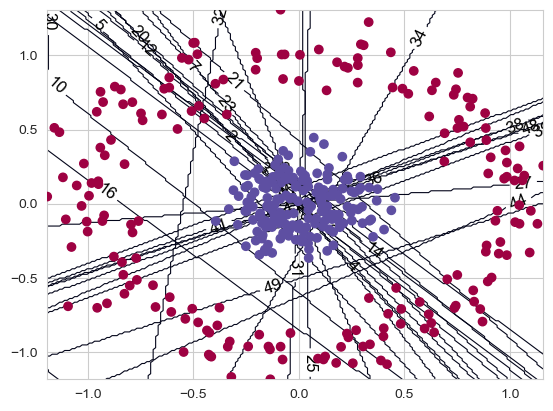

In [8]:
## Generating visualizations for the decision boundary for each fit

db_plotter(X_train, y_train, a.c_array, multiple_estimators=True)

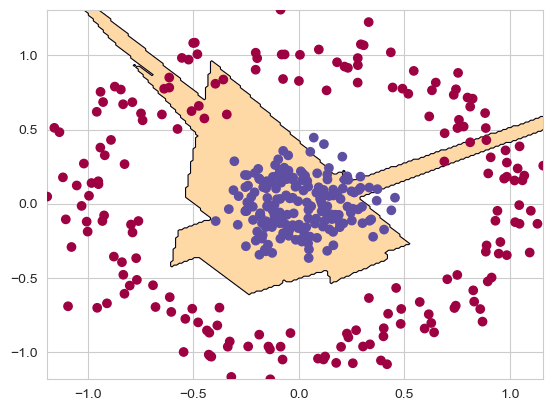

In [9]:
## Generating visualizations for the final decision boundary

db_plotter(X_train, y_train, a, multiple_estimators=False)

## Task-2

#### Running AdaBoost with Logistic Regression and tuning it

In [10]:
from sklearn.model_selection import GridSearchCV

a = AdaBoost(classifier = "LOGREG", n_learners=100)
params = {
    "eta": np.arange(0.5, 0.7, 0.05),
    "log_reg_C": np.arange(0.01, 0.3, 0.05), 
    "log_reg_penalty": ["l1", "l2"],
    "log_reg_solver": ["liblinear"]
}
gcv = GridSearchCV(a, params, error_score="raise")
gcv.fit(X_train, y_train)
best_logreg = gcv.best_estimator_
best_logreg

AdaBoost(classifier='LOGREG', eta=0.6000000000000001,
         log_reg_C=0.21000000000000002, log_reg_solver='liblinear',
         n_learners=100)

In [11]:
# Checking the performance on the training and test dataset
train_acc = accuracy_score(best_logreg.predict(X_train), y_train)
test_acc = accuracy_score(best_logreg.predict(X_test), y_test)

print("training accuracy:", train_acc)
print("test accuracy:", test_acc)

training accuracy: 1.0
test accuracy: 1.0


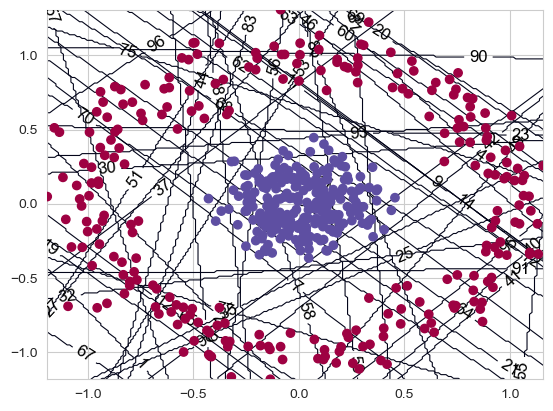

In [12]:
## Generating visualizations for the decision boundary for each fit on the entire dataset

db_plotter(X, y, best_logreg.c_array, multiple_estimators=True)

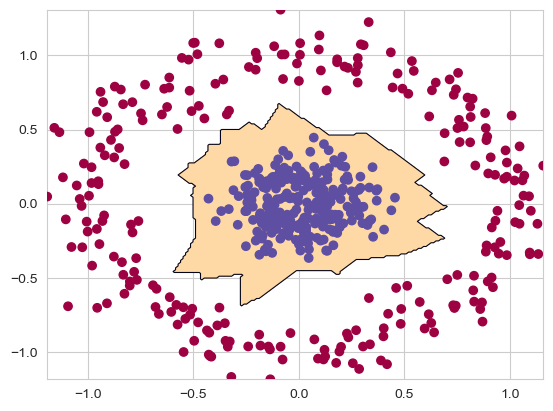

In [13]:
## Generating visualizations for the final decision boundary on the entire dataset

db_plotter(X, y, best_logreg, multiple_estimators=False)

By tuning the parameters of Adaboost and logistic regression weak learner, we are able to get 100% accuracy on the training set and the test set. Note that although logistic regression is not a weak learner, since the dataset is non-linear, logistic regression can be considered a weak learner by iteself.

#### Running AdaBoost with Decision Stump and tuning it

In [14]:
from sklearn.model_selection import GridSearchCV

a = AdaBoost(classifier = "DT_Stump", n_learners=50)
params = {
    "eta": np.arange(0.5, 1, 0.05),
    "dts_max_features" : [1,2]
}
gcv = GridSearchCV(a, params, error_score="raise")
gcv.fit(X_train, y_train)
best_dt_stump = gcv.best_estimator_
best_dt_stump

AdaBoost(dts_max_features=2, eta=0.9000000000000004)

In [15]:
# Checking the performance on the training and test dataset
train_acc = accuracy_score(best_dt_stump.predict(X_train), y_train)
test_acc = accuracy_score(best_dt_stump.predict(X_test), y_test)

print("training accuracy:", train_acc)
print("test accuracy:", test_acc)

training accuracy: 1.0
test accuracy: 0.992


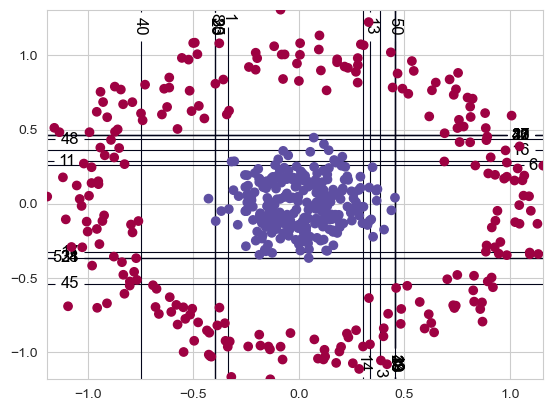

In [16]:
## Generating visualizations for the decision boundary for each fit on the entire dataset

db_plotter(X, y, best_dt_stump.c_array, multiple_estimators=True)

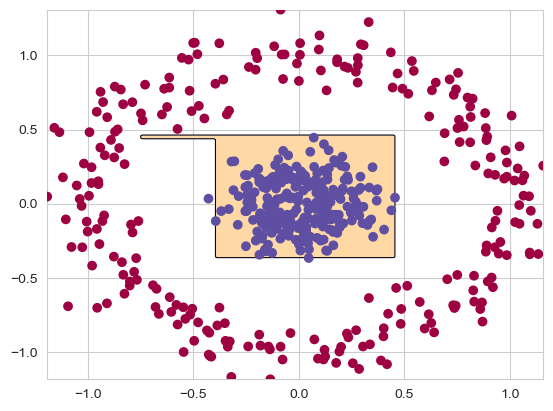

In [17]:
## Generating visualizations for the final decision boundary on the entire dataset

db_plotter(X, y, best_dt_stump, multiple_estimators=False)

By tuning the parameters of Adaboost and Decision Tree Stump as a weak learner, we are able to get 100% accuracy on the training set and 99.2% accuracy on the test set.

#### Running AdaBoost with Decision Tree and tuning it

In [18]:
from sklearn.model_selection import GridSearchCV

a = AdaBoost(classifier = "DT", n_learners=10)
params = {
    "eta": np.arange(0.5, 1, 0.05),
    "dt_max_features" : [1,2],
    "dt_min_samples_leaf": np.arange(1, 20, 5).astype(int)
}
gcv = GridSearchCV(a, params, error_score="raise")
gcv.fit(X_train, y_train)
best_dt = gcv.best_estimator_
best_dt

AdaBoost(classifier='DT', dt_max_features=2, dt_min_samples_leaf=16,
         eta=0.9500000000000004, n_learners=10)

In [19]:
# Checking the performance on the training and test dataset

train_acc = accuracy_score(best_dt.predict(X_train), y_train)
test_acc = accuracy_score(best_dt.predict(X_test), y_test)

print("training accuracy:", train_acc)
print("test accuracy:", test_acc)

training accuracy: 1.0
test accuracy: 1.0


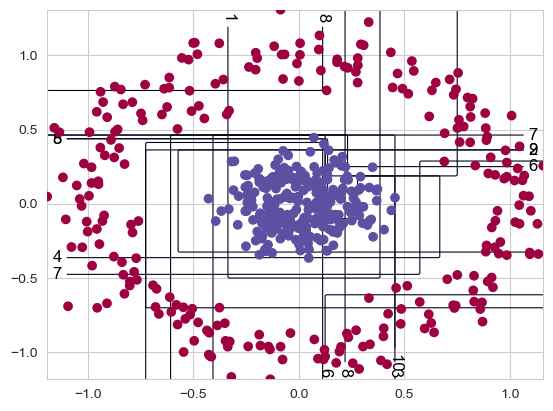

In [20]:
## Generating visualizations for the decision boundary for each fit on the entire dataset

db_plotter(X, y, best_dt.c_array, multiple_estimators=True)

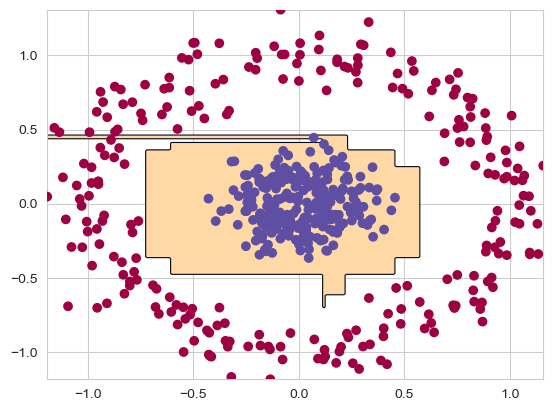

In [21]:
## Generating visualizations for the final decision boundary on the entire dataset

db_plotter(X, y, best_dt, multiple_estimators=False)

By tuning the parameters of Adaboost and Decision Tree, we are able to get 100% accuracy on the training set and 100% accuracy on the test set. Note that since decision tree is in itself a relatively strong learner, we had limited the depth of deicision tree to 3. Even with this limitation, we are able to achieve 100% accuracy using decision tree as a weak learner with less number of iterations of AdaBoost (only 10 iterations).

#### Running AdaBoost with Linear SVC and tuning it

In [22]:
from sklearn.model_selection import GridSearchCV

a = AdaBoost(classifier = "SVC", n_learners=100)
params = {
    "eta": np.arange(0.5, 0.7, 0.05),
    "svc_penalty": ["l1", "l2"],
    "svc_C": np.arange(0.05, 0.2, 0.01)
}
gcv = GridSearchCV(a, params, error_score="raise")
gcv.fit(X_train, y_train)
best_svc = gcv.best_estimator_
best_svc

AdaBoost(classifier='SVC', eta=0.6000000000000001, n_learners=100, svc_C=0.14)

In [23]:
# Checking the performance on the training and test dataset

train_acc = accuracy_score(best_svc.predict(X_train), y_train)
test_acc = accuracy_score(best_svc.predict(X_test), y_test)

print("training accuracy:", train_acc)
print("test accuracy:", test_acc)

training accuracy: 1.0
test accuracy: 0.992


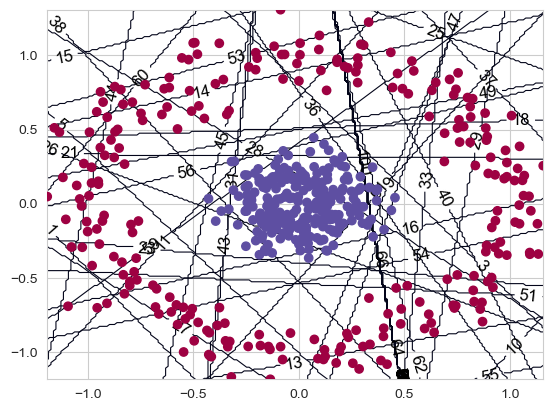

In [24]:
## Generating visualizations for the decision boundary for each fit on the entire dataset

db_plotter(X, y, best_svc.c_array, multiple_estimators=True)

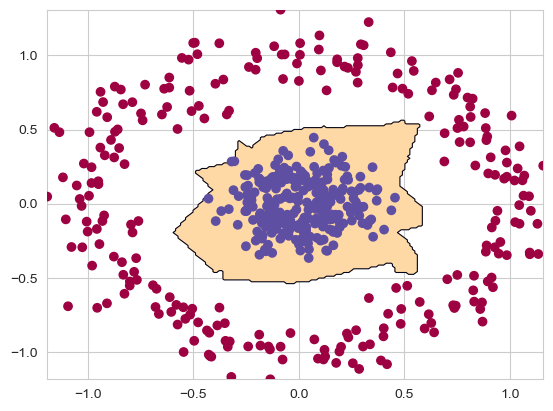

In [25]:
## Generating visualizations for the final decision boundary on the entire dataset

db_plotter(X, y, best_svc, multiple_estimators=False)

By tuning the parameters of Adaboost and Linear SVM, we are able to get 100% accuracy on the training set and 99.2% accuracy on the test set. Note that since SVM is in itself a relatively strong learner, since it's a linear model, we can consider it to be a weak learner as the dataset in non-linear.

#### Running AdaBoost with LDA and tuning it

In [64]:
from sklearn.model_selection import GridSearchCV

a = AdaBoost(classifier = "LDA", n_learners=100)
params = {
    "eta": np.arange(0.9, 0.95, 0.025),
    "lda_solver": ['svd', 'lsqr', 'eigen']
}
gcv = GridSearchCV(a, params, error_score="raise")
gcv.fit(X_train, y_train)
best_lda = gcv.best_estimator_
best_lda

AdaBoost(classifier='LDA', eta=0.925, n_learners=100)

In [65]:
# Checking the performance on the training and test dataset

train_acc = accuracy_score(best_lda.predict(X_train), y_train)
test_acc = accuracy_score(best_lda.predict(X_test), y_test)

print("training accuracy:", train_acc)
print("test accuracy:", test_acc)

training accuracy: 0.944
test accuracy: 0.952


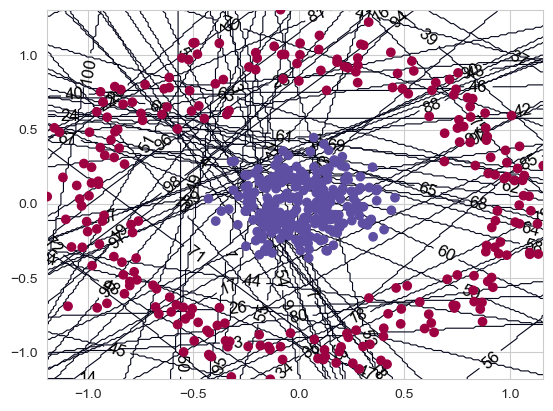

In [66]:
## Generating visualizations for the decision boundary for each fit on the entire dataset

db_plotter(X, y, best_lda.c_array, multiple_estimators=True)

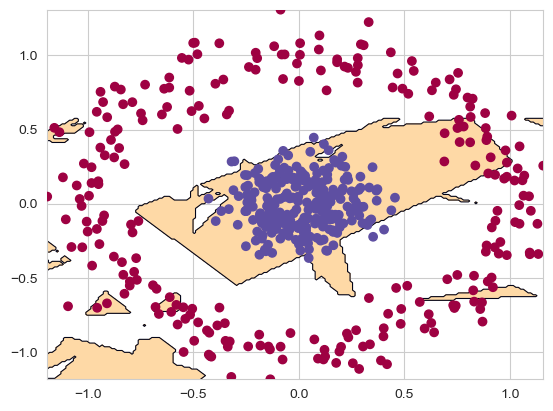

In [67]:
## Generating visualizations for the final decision boundary on the entire dataset

db_plotter(X, y, best_lda, multiple_estimators=False)

By tuning the parameters of Adaboost and LDA, we are able to get 94.4% accuracy on the training set and 95.2% accuracy on the test set. LDA's performance with AdaBoost is the least satisfactory as it's decision boundary even after 100 iterations is very jagged and uneven. This is also reflected in its training and test accuracy scores, which are the lowest among the models.